# Using Reddit's API for Predicting Comments

##### Christopher Manley
##### General Assembly DSI-5

#### Introduction


In this project I have collected data from 2 different subreddits via Reddits's API and built a binary predictor to determine, using NLP and ML Models, which Subreddit a given post is from.

I have selected 2 subreddits, 'The Onion' and 'Not the Onion' from which to scrape my data. These subreddits will use very common language and I expect that my models will have difficulty predicting with very high acurracy.

To test this theory I will use the model that acheives the best score on this data to predict the source subreddit using 2 different subreddits with disparate topics and language, r/literature and r/physics.

To view the recorded presentation on YouTube, please visit:
https://youtu.be/qdq9_bGoROU

### Scraping Thread Info from Reddit.com

I have created a scraping function that is stored in a separate notebook called 'Web Scraping'

In [1]:
import requests
import json
import pandas as pd
import requests
import time

#### Preparing the dataframes
Getting results from the CSV.
If you want to see the scraping function checkout my 'Web Scrape Function' notebook

In [2]:
onion_data = pd.read_csv('./theonion.csv')
notonion_data = pd.read_csv('./nottheonion.csv')

Creating a text column with titles and post text

In [3]:
onion_data['selftext'].fillna('', inplace=True)
onion_data['text'] = onion_data['title'] + onion_data['selftext']
onion_data[['text', 'selftext', 'title']].head()

,text,selftext,title
0,Fabled Lost City Of Gold Finally Discovered Of...,,Fabled Lost City Of Gold Finally Discovered Of...
1,Purina Introduces ‘Own Shit’ Dog Food Flavor,,Purina Introduces ‘Own Shit’ Dog Food Flavor
2,Does Brett Kavanaugh’s 1996 Legal Essay ‘Donal...,,Does Brett Kavanaugh’s 1996 Legal Essay ‘Donal...
3,PR Disaster: Nike Is Under Fire After It Relea...,,PR Disaster: Nike Is Under Fire After It Relea...
4,Is It Fair To Not Pay College Football Players...,,Is It Fair To Not Pay College Football Players...


In [4]:
notonion_data['selftext'].fillna('', inplace=True)
notonion_data['text'] = notonion_data['title'] + notonion_data['selftext']
notonion_data[['text', 'selftext', 'title']].head()

,text,selftext,title
0,Rocket City Trash Pandas chosen as new Madison...,,Rocket City Trash Pandas chosen as new Madison...
1,2K asks fans to tell Belgium they want loot boxes,,2K asks fans to tell Belgium they want loot boxes
2,Coastal Labs Studying Increased Flooding Consi...,,Coastal Labs Studying Increased Flooding Consi...
3,Twentieth Century Fox pulls scene from 'The Pr...,,Twentieth Century Fox pulls scene from 'The Pr...
4,Tour of Britain bike turned into penis,,Tour of Britain bike turned into penis


Preparing taget column and combining the Dataframes

In [5]:
onion_data['subreddit'].replace(to_replace='TheOnion', value=1, inplace=True)
notonion_data['subreddit'].replace(to_replace='nottheonion', value=0, inplace=True)
df2 = pd.concat(objs=(onion_data, notonion_data), axis=0, ignore_index=True)
full_df = df2.loc[:, ['text', 'subreddit']]
full_df.head()

,text,subreddit
0,Fabled Lost City Of Gold Finally Discovered Of...,1
1,Purina Introduces ‘Own Shit’ Dog Food Flavor,1
2,Does Brett Kavanaugh’s 1996 Legal Essay ‘Donal...,1
3,PR Disaster: Nike Is Under Fire After It Relea...,1
4,Is It Fair To Not Pay College Football Players...,1


Creating X and y matrices

In [6]:
X = full_df['text']
y = full_df['subreddit'] 

#### Modeling Data
Importing necessary libraries

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Checking balance of data and determining baseline accuracy

In [8]:
full_df['subreddit'].value_counts()/full_df.shape[0]

1    0.515219
0    0.484781
Name: subreddit, dtype: float64

Very balanced data set, TheOnion is the dominant class with %51. That is my baseline prediction.

Train, test, split

In [9]:
X = full_df['text']
y = full_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28, stratify=y)
X_train.head()

3386    News: Safety First: To Avoid Rio’s Polluted Wa...
2145        I Can't Stand It When Jews Talk During Movies
403     ‘In Office, I Only Ate 7 Almonds A Day. As A P...
5428    This barber will publicly shame your misbehavi...
6166    Sean Spicer stole a mini fridge from Junior Wh...
Name: text, dtype: object

### EDA

Fitting a count vectorizer to get a sense of the most popular words

In [10]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english') 

X_train_trans = cvec.fit_transform(X_train)
X_test_trans = cvec.transform(X_test)
X_train_trans

<5026x11819 sparse matrix of type '<class 'numpy.int64'>'
	with 42361 stored elements in Compressed Sparse Row format>

In [11]:
trans_df = pd.DataFrame(X_train_trans.todense(),
                   columns=cvec.get_feature_names())

trans_df.head()

,00,000,000th,001,030,045,07,10,100,1000,...,zombies,zone,zones,zoo,zooey,zookeeper,zoologist,zopittybop,zuckerberg,zune
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Plotting the most frequently used words in "The Onion" and "Not The Onion" posts.
- since I've already combined my data and train, test, split, I'm going to create vectorized DataFrames for both the onion and not the onion. I will use the binary classifications of the subreddits to accomplish this.

In [12]:
onion_vect = pd.DataFrame(X_train_trans.todense(), 
                          columns=cvec.get_feature_names()).reindex(y_train[y_train == 1].index)
top_onion = onion_vect.mean().sort_values(ascending=False).iloc[:10]
top_onion.values

array([0.07609115, 0.05755118, 0.04557744, 0.04480494, 0.04248745,
       0.0405562 , 0.03939745, 0.0382387 , 0.03630745, 0.03051371])

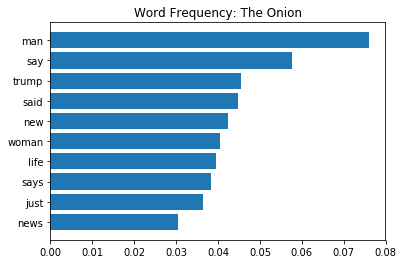

In [13]:
top_onion = top_onion.sort_values(ascending=True)
plt.barh(top_onion.index, top_onion.values)
plt.title('Word Frequency: The Onion');

In [14]:
nottheonion_vect = pd.DataFrame(X_train_trans.todense(), 
                          columns=cvec.get_feature_names()).reindex(y_train[y_train == 0].index)
top_nottheonion = nottheonion_vect.mean().sort_values(ascending=False).iloc[:10]
top_nottheonion.values

array([0.0877193 , 0.05513784, 0.04427736, 0.04427736, 0.04010025,
       0.03926483, 0.03759398, 0.03592314, 0.03508772, 0.0342523 ])

In [15]:
type(top_nottheonion)

pandas.core.series.Series

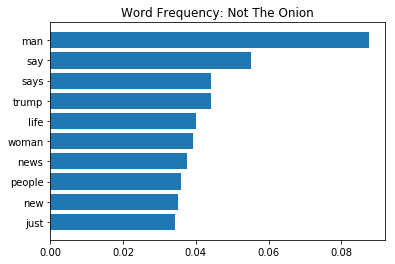

In [16]:
top_nottheonion = top_nottheonion.sort_values(ascending=True)
plt.barh(top_nottheonion.index, top_nottheonion.values)
plt.title('Word Frequency: Not The Onion');

Extremely similar lists for word frequency!

### Fitting Models

#### TF-IDF, Gridsearch and Random Forest

In [17]:
tvec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english') 

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
X_train_tvec

<5026x11819 sparse matrix of type '<class 'numpy.float64'>'
	with 42361 stored elements in Compressed Sparse Row format>

In [18]:
tvec_df = pd.DataFrame(X_train_tvec.todense(),
                   columns=tvec.get_feature_names())
tvec_df.head()

,00,000,000th,001,030,045,07,10,100,1000,...,zombies,zone,zones,zoo,zooey,zookeeper,zoologist,zopittybop,zuckerberg,zune
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
rf = RandomForestClassifier()

grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]}
               #'min_samples_split': [2, 5, 10],
               #'min_samples_leaf': [1, 2, 4]}

rf_grid = GridSearchCV(estimator = rf, 
                       param_grid = grid, 
                       cv = 5, 
                       verbose=2,
                       n_jobs = -1)

rf_grid = rf_grid.fit(X_train_tvec, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
[CV] max_depth=10, n_estimators=10 ...................................
[CV] max_depth=10, n_estimators=10 ...................................
[CV] max_depth=10, n_estimators=10 ...................................
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .................... max_depth=10, n_estimators=10, total=   0.2s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .................... max_depth=10, n_estimators=10, total=   0.1s
[CV] max_depth=10, n_estimators=20 ...................................
[CV] .................... max_depth=10, n_estimators=10, total=   0.1s
[CV] max_depth=10, n_estimators=20 ...................................
[CV] .................... max_depth=10, n_estimators=10, total=   0.2s
[CV] .................... max_depth=10, n_estimators=10, total=   0.1s
[CV] max_depth=10, n_estimators=20 ...................................
[CV] max_depth

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    9.5s


[CV] .................... max_depth=20, n_estimators=10, total=   0.2s
[CV] max_depth=20, n_estimators=20 ...................................
[CV] .................... max_depth=20, n_estimators=10, total=   0.2s
[CV] max_depth=20, n_estimators=20 ...................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.2s
[CV] max_depth=20, n_estimators=20 ...................................
[CV] .................... max_depth=20, n_estimators=20, total=   0.4s
[CV] max_depth=20, n_estimators=20 ...................................
[CV] .................... max_depth=20, n_estimators=20, total=   0.4s
[CV] max_depth=20, n_estimators=30 ...................................
[CV] .................... max_depth=20, n_estimators=20, total=   0.4s
[CV] max_depth=20, n_estimators=30 ...................................
[CV] .................... max_depth=20, n_estimators=20, total=   0.4s
[CV] max_depth=20, n_estimators=30 ...................................
[CV] .

[CV] .................... max_depth=30, n_estimators=30, total=   0.8s
[CV] max_depth=30, n_estimators=30 ...................................
[CV] .................... max_depth=30, n_estimators=30, total=   0.8s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=30, total=   0.8s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=30, total=   0.7s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=30, total=   0.8s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=40, total=   1.0s
[CV] max_depth=30, n_estimators=40 ...................................
[CV] .................... max_depth=30, n_estimators=40, total=   1.0s
[CV] max_depth=30, n_estimators=50 ...................................
[CV] .

[CV] .................... max_depth=40, n_estimators=40, total=   1.3s
[CV] max_depth=40, n_estimators=50 ...................................
[CV] .................... max_depth=40, n_estimators=40, total=   1.3s
[CV] max_depth=40, n_estimators=50 ...................................
[CV] .................... max_depth=40, n_estimators=50, total=   1.5s
[CV] max_depth=40, n_estimators=50 ...................................


[Parallel(n_jobs=-1)]: Done 171 tasks      | elapsed:   46.7s


[CV] .................... max_depth=40, n_estimators=50, total=   1.6s
[CV] max_depth=40, n_estimators=60 ...................................
[CV] .................... max_depth=40, n_estimators=50, total=   1.6s
[CV] max_depth=40, n_estimators=60 ...................................
[CV] .................... max_depth=40, n_estimators=50, total=   1.6s
[CV] max_depth=40, n_estimators=60 ...................................
[CV] .................... max_depth=40, n_estimators=50, total=   1.5s
[CV] max_depth=40, n_estimators=60 ...................................
[CV] .................... max_depth=40, n_estimators=60, total=   1.9s
[CV] max_depth=40, n_estimators=60 ...................................
[CV] .................... max_depth=40, n_estimators=60, total=   1.8s
[CV] max_depth=40, n_estimators=70 ...................................
[CV] .................... max_depth=40, n_estimators=60, total=   1.8s
[CV] max_depth=40, n_estimators=70 ...................................
[CV] .

[CV] .................... max_depth=50, n_estimators=60, total=   2.2s
[CV] max_depth=50, n_estimators=70 ...................................
[CV] .................... max_depth=50, n_estimators=70, total=   2.6s
[CV] max_depth=50, n_estimators=70 ...................................
[CV] .................... max_depth=50, n_estimators=70, total=   2.5s
[CV] max_depth=50, n_estimators=80 ...................................
[CV] .................... max_depth=50, n_estimators=70, total=   2.6s
[CV] max_depth=50, n_estimators=80 ...................................
[CV] .................... max_depth=50, n_estimators=70, total=   2.5s
[CV] max_depth=50, n_estimators=80 ...................................
[CV] .................... max_depth=50, n_estimators=70, total=   2.5s
[CV] max_depth=50, n_estimators=80 ...................................
[CV] .................... max_depth=50, n_estimators=80, total=   2.9s
[CV] max_depth=50, n_estimators=80 ...................................
[CV] .

[CV] .................... max_depth=60, n_estimators=80, total=   3.4s
[CV] max_depth=60, n_estimators=90 ...................................
[CV] .................... max_depth=60, n_estimators=80, total=   3.4s
[CV] max_depth=60, n_estimators=90 ...................................
[CV] .................... max_depth=60, n_estimators=80, total=   3.3s
[CV] max_depth=60, n_estimators=90 ...................................
[CV] .................... max_depth=60, n_estimators=90, total=   3.7s
[CV] max_depth=60, n_estimators=90 ...................................
[CV] .................... max_depth=60, n_estimators=90, total=   3.7s
[CV] max_depth=60, n_estimators=100 ..................................
[CV] .................... max_depth=60, n_estimators=90, total=   3.6s
[CV] max_depth=60, n_estimators=100 ..................................
[CV] .................... max_depth=60, n_estimators=90, total=   3.7s
[CV] max_depth=60, n_estimators=100 ..................................
[CV] .

[CV] ................... max_depth=70, n_estimators=100, total=   4.7s
[CV] max_depth=70, n_estimators=100 ..................................
[CV] ................... max_depth=70, n_estimators=100, total=   4.7s
[CV] max_depth=80, n_estimators=10 ...................................
[CV] .................... max_depth=80, n_estimators=10, total=   0.5s
[CV] max_depth=80, n_estimators=10 ...................................
[CV] ................... max_depth=70, n_estimators=100, total=   4.6s
[CV] max_depth=80, n_estimators=10 ...................................
[CV] .................... max_depth=80, n_estimators=10, total=   0.5s
[CV] max_depth=80, n_estimators=10 ...................................
[CV] .................... max_depth=80, n_estimators=10, total=   0.5s
[CV] max_depth=80, n_estimators=10 ...................................
[CV] .................... max_depth=80, n_estimators=10, total=   0.5s
[CV] max_depth=80, n_estimators=20 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done 374 tasks      | elapsed:  2.8min


[CV] .................... max_depth=80, n_estimators=50, total=   2.6s
[CV] max_depth=80, n_estimators=60 ...................................
[CV] .................... max_depth=80, n_estimators=60, total=   3.2s
[CV] max_depth=80, n_estimators=60 ...................................
[CV] .................... max_depth=80, n_estimators=60, total=   3.1s
[CV] max_depth=80, n_estimators=70 ...................................
[CV] .................... max_depth=80, n_estimators=60, total=   3.1s
[CV] max_depth=80, n_estimators=70 ...................................
[CV] .................... max_depth=80, n_estimators=60, total=   3.1s
[CV] max_depth=80, n_estimators=70 ...................................
[CV] .................... max_depth=80, n_estimators=60, total=   3.1s
[CV] max_depth=80, n_estimators=70 ...................................
[CV] .................... max_depth=80, n_estimators=70, total=   3.6s
[CV] max_depth=80, n_estimators=70 ...................................
[CV] .

[CV] .................... max_depth=90, n_estimators=70, total=   3.9s
[CV] max_depth=90, n_estimators=80 ...................................
[CV] .................... max_depth=90, n_estimators=70, total=   4.0s
[CV] max_depth=90, n_estimators=80 ...................................
[CV] .................... max_depth=90, n_estimators=70, total=   3.9s
[CV] max_depth=90, n_estimators=80 ...................................
[CV] .................... max_depth=90, n_estimators=80, total=   4.4s
[CV] max_depth=90, n_estimators=80 ...................................
[CV] .................... max_depth=90, n_estimators=80, total=   4.4s
[CV] max_depth=90, n_estimators=90 ...................................
[CV] .................... max_depth=90, n_estimators=80, total=   4.4s
[CV] max_depth=90, n_estimators=90 ...................................
[CV] .................... max_depth=90, n_estimators=80, total=   4.4s
[CV] max_depth=90, n_estimators=90 ...................................
[CV] .

[CV] ................... max_depth=100, n_estimators=90, total=   5.3s
[CV] max_depth=100, n_estimators=90 ..................................
[CV] ................... max_depth=100, n_estimators=90, total=   5.3s
[CV] max_depth=100, n_estimators=100 .................................
[CV] ................... max_depth=100, n_estimators=90, total=   5.3s
[CV] max_depth=100, n_estimators=100 .................................
[CV] ................... max_depth=100, n_estimators=90, total=   5.2s
[CV] max_depth=100, n_estimators=100 .................................
[CV] ................... max_depth=100, n_estimators=90, total=   5.3s
[CV] max_depth=100, n_estimators=100 .................................
[CV] .................. max_depth=100, n_estimators=100, total=   5.8s
[CV] max_depth=100, n_estimators=100 .................................
[CV] .................. max_depth=100, n_estimators=100, total=   5.8s
[CV] max_depth=110, n_estimators=10 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  5.4min finished


In [20]:
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.7526860326303223
{'max_depth': 110, 'n_estimators': 70}


In [21]:
rf_grid.best_estimator_.feature_importances_

array([3.05690327e-07, 7.11625050e-04, 2.39484885e-06, ...,
       0.00000000e+00, 1.95863847e-05, 4.90830997e-06])

In [22]:
features_strength = zip(tvec.get_feature_names(), rf_grid.best_estimator_.feature_importances_);
sorted(features_strength, key=lambda x: abs(x[1]), reverse=True)

[('life', 0.03090112451255334),
 ('said', 0.03076077556206616),
 ('say', 0.027155140024125012),
 ('news', 0.0204446567892565),
 ('says', 0.01888233267371705),
 ('police', 0.01730576445941477),
 ('just', 0.016076061634122656),
 ('trump', 0.013826898570292874),
 ('nation', 0.010854841369680023),
 ('man', 0.009752842073333235),
 ('questions', 0.008156733945047573),
 ('onion', 0.008024235836156033),
 ('woman', 0.007816087326939144),
 ('arrested', 0.007392999624534591),
 ('sex', 0.006683653660002122),
 ('report', 0.006625240674863933),
 ('shit', 0.005987713164928752),
 ('know', 0.0059697055183921405),
 ('way', 0.005545704962004079),
 ('time', 0.0053541370975649216),
 ('things', 0.004996470857707302),
 ('quiz', 0.004914706768553551),
 ('video', 0.004778887938109567),
 ('fucking', 0.004408084401833905),
 ('claims', 0.004314247106236055),
 ('incredible', 0.004289201294229324),
 ('texas', 0.00417813876958389),
 ('chinese', 0.003908900339307558),
 ('blog', 0.0038713428493366247),
 ('gets', 0.003

In [23]:
rf_grid.best_estimator_.predict(X_test_tvec)
rf_grid.best_estimator_.score(X_test_tvec, y_test)

0.7768496420047732

The Random Forest model acheived a score .753 on the training data and .777 on the test data. This clearly beats the baseline prediction of %51.5. It appears, however, that this dataset is difficult for a machine to make very accurate predictions on. This is not altogether surprising as the point of the "Not The Onion" subreddit is to feature real news headlines that sound, at least to humans, like they could have been featured in The Onion. While this model did pretty well considering the data set, I think we might be able to do better with a Logistic Regression.

#### TF-IDF Logistic Regression

In [25]:
lr = LogisticRegression()
lr.fit(X_train_tvec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
cross_val_score(lr, X_train_tvec, y_train, cv=5).mean()

0.7815389402302957

In [27]:
lr.score(X_test_tvec, y_test)

0.7911694510739857

As we can see a simple Logistic Regression actually does better with this data than the GridSearch/Random Forest model, with a score of .79. Let's see a plot of the most predictive words.

In [27]:
feature_names = tvec.get_feature_names()
feature_coefs = list(lr.coef_[0])
feature_df = pd.DataFrame([feature_names, feature_coefs]).T
feature_df.head()

,0,1
0,00,0.107926
1,000,0.197873
2,000th,-0.144077
3,001,0.0747369
4,030,-0.145685


In [35]:
top_predictors = feature_df.reindex(feature_df[1].abs().sort_values(ascending=False).index)[:10]
top_predictors

,0,1
9153,said,5.18723
6228,life,5.03475
9235,says,-4.2198
8009,police,-3.54996
7170,news,3.51695
10931,trump,3.29037
7086,nation,3.10739
9233,say,3.01583
5791,just,2.90117
8444,questions,2.70627


In [44]:
tp = top_predictors.reindex(top_predictors[1].abs().sort_values(ascending=True).index)

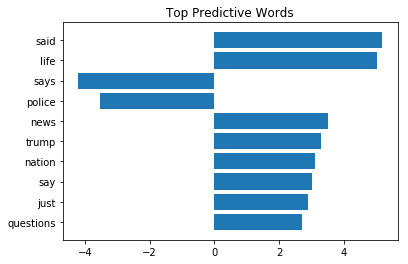

In [45]:
plt.barh(tp[0], tp[1], )
plt.title('Top Predictive Words');

#### Testing the model on different data

- Importing literature and physics subreddit data

In [46]:
lit_data = pd.read_csv('./literature.csv')
physics_data = pd.read_csv('./physics.csv')

Creating 'text' columns and filling in NaN values.

In [47]:
lit_data['selftext'].fillna('', inplace=True)
lit_data['text'] = lit_data['title'] + lit_data['selftext']
lit_data[['text', 'selftext', 'title']].head()

,text,selftext,title
0,The FBI’s Spying on Writers Was Literary Criti...,,The FBI’s Spying on Writers Was Literary Criti...
1,Chekov &amp; Tolstoy,,Chekov &amp; Tolstoy
2,"John Steinbeck was a sadistic womaniser, says ...",,"John Steinbeck was a sadistic womaniser, says ..."
3,In Praise of the Epistolary Novel,,In Praise of the Epistolary Novel
4,Jorge Luis Borges Selects 74 Books for Your Pe...,,Jorge Luis Borges Selects 74 Books for Your Pe...


In [48]:
physics_data['selftext'].fillna('', inplace=True)
physics_data['text'] = physics_data['title'] + physics_data['selftext']
physics_data[['text', 'selftext', 'title']].head()

,text,selftext,title
0,"Physics Questions Thread - Week 36, 2018**Tues...",**Tuesday Physics Questions: 04-Sep-2018**\n\n...,"Physics Questions Thread - Week 36, 2018"
1,"Careers/Education Questions Thread - Week 36, ...",**Thursday Careers &amp; Education Advice Thre...,"Careers/Education Questions Thread - Week 36, ..."
2,This symbol is engraved outside the institute ...,,This symbol is engraved outside the institute ...
3,Teaching some physics with a homemade experiment,,Teaching some physics with a homemade experiment
4,Today is the 10-year anniversary of the first ...,,Today is the 10-year anniversary of the first ...


Creating concatenated dataframe and setting up X and y targets

In [49]:
lit_data['subreddit'].replace(to_replace='literature', value=1, inplace=True)
physics_data['subreddit'].replace(to_replace='Physics', value=0, inplace=True)
lit_phys_df = pd.concat(objs=(lit_data, physics_data), axis=0, ignore_index=True)
full_df2 = lit_phys_df.loc[:, ['text', 'subreddit']]

In [50]:
X2 = full_df2['text']
y2 = full_df2['subreddit'] 

In [51]:
full_df2['subreddit'].value_counts()/full_df2.shape[0]
full_df2.head()

,text,subreddit
0,The FBI’s Spying on Writers Was Literary Criti...,1
1,Chekov &amp; Tolstoy,1
2,"John Steinbeck was a sadistic womaniser, says ...",1
3,In Praise of the Epistolary Novel,1
4,Jorge Luis Borges Selects 74 Books for Your Pe...,1


Train, test, split and fitting the TF-IDF Vectorizer

In [53]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=28, stratify=y2)

In [54]:
second_tvec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english') 

X2_train_tvec = second_tvec.fit_transform(X2_train)
X2_test_tvec = second_tvec.transform(X2_test)

In [55]:
tvec_df2 = pd.DataFrame(X2_train_tvec.todense(),
                   columns=second_tvec.get_feature_names())

In [57]:
lr2 = LogisticRegression()
lr2.fit(X2_train_tvec, y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [58]:
cross_val_score(lr2, X2_train_tvec, y2_train, cv=5).mean()

0.9332860527154004

In [59]:
lr2.score(X2_test_tvec, y2_test)

0.9500520291363164

#### Conclusion

So, as suspected, the same logistic regression model used on the 'Onion' and 'Not the Onion' data performs significantly better on data with disparate topics (In this case Literature and Physics). The point of this exercise is to demonstrate how similar the news headlines posted on the Onion are to real news stories on Not the Onion.

# Executive Summary

The institute for Integrity in News Reporting has asked General Assembly to analyze real and satirical news headlines in an effort to understand how similar these headlines can actually sound. The goal of this presentation is to examine a large dataset of news headlines, and using Natural Language Processing and Machine Learning models, predict if that headline is from a real news source or a satirical news source.

The Problem: Over the past few years, and especially since the run-up to the 2016 presidential election, concern has grown around the legitimacy of news stories circulating on social media. The term 'fake news' is often applied to these erroneous or misleading news stories (admittedly, this term is thrown around loosely and judging which stories are 'fake' is often a matter of political affiliation). Regardless of political affiliation, the Institute for Integrity in News Reporting is interested in exploring ways to more quickly and accurately identify and denounce truly fake and misleading news stories in wide circulation on social media. Several tech companies, including Facebook and Twitter have begun exploring technology to accomplish this and the Institute is interested in understanding and utilizing this technology.

In this examination we will mainly be focused on 2 specific 'subreddits.' Our satirical news source is 'The Onion' subreddit and our real news source is the 'not the onion' subreddit. 

The Subreddits: The Onion is a well known humor and satire site, famous for creating entirely fake and funny news stories. While most people are aware that the Onion is a satire site, replies from individuals who seem to take these news stories as real stories can still be found all over the internet.
Not the Onion is a subreddit devoted to real news stories from reliable news sources, that sound like they could be Onion articles.

The Dataset: Using Reddit's API I have scraped 3,453 unique posts from 'The Onion' subreddit and 3,249 unique posts from the 'Not the Onion' subreddit. The Onion represents 51.5% of the total data, which means we have a very balanced dataset.

Conclusions: While machine learning models perform considerably better than the baseline prediction of 51.5% percent, more advanced models and techniques than NLP alone need to be employed to identify satirical news stories with high accuracy.  

